In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from colour import Color
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from model.forest import train_forest
from typing import Optional
from pandas import DataFrame, Series
from seaborn.matrix import ClusterGrid

In [5]:
data = pd.read_csv("../data/genes_transformed.csv", delimiter=",", decimal='.')

In [6]:
colors = ["#00FF00", "#000000", "#FF0000"]
cmap = LinearSegmentedColormap.from_list("gene", [Color( c1 ).rgb for c1 in colors])

In [7]:
def get_importances(importances: np.ndarray, feature_names: list[str], top: int = 10):
  sorted_importances = { name: importance for importance, name in sorted(zip(importances, feature_names), key=lambda x: x[0], reverse=True) }
  return pd.Series(data=sorted_importances)[:top]

In [8]:
def plot_clustermap(cluster_data: DataFrame, col_colors: list[Series]) -> ClusterGrid:
  return sns.clustermap(np.log2(cluster_data, out=np.zeros_like(cluster_data), where=cluster_data != 0), col_colors=col_colors, method="ward", z_score=0, metric="euclidean", cmap=cmap, vmin=-4, vmax=4)

def plot_legend(g: ClusterGrid, subtypes: Series, lut: dict):
  for label in subtypes.unique():
      g.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)

  g.ax_col_dendrogram.legend(title='Subtype', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.8))

In [9]:
def show_cluster(metric: str, top: int = 10, features: Optional[int] = None):
  response = train_forest(metric, features=features, data=data)

  print(f"Acc: {response.acc}, F1 Score: {response.f1}")
  importances = get_importances(response.model.feature_importances_, response.feature_names, top=top)
  sns.barplot(x=importances, y=importances.index, orient='h').set(xlabel='Importance', ylabel='Gene', title=f"Importância de cada gene ({metric})")

  subtypes = data["subtype"]
  palette = sns.cubehelix_palette(subtypes.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
  lut = dict(zip(map(str, subtypes.unique()), palette))
  col_colors = [subtypes.map(lut), data["prognostic"].map({ "POOR": "r", "GOOD": "g", "MODERATE": "y", "UNKNOWN": "black" })]

  cluster_data = data.drop(axis=1, labels=["prognostic", "subtype"])[importances.index].transpose()

  g = plot_clustermap(cluster_data, col_colors=col_colors)
  plot_legend(g, subtypes, lut)

  plt.show()

Acc: 0.8552125341862513, F1 Score: 0.885363418258155


/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


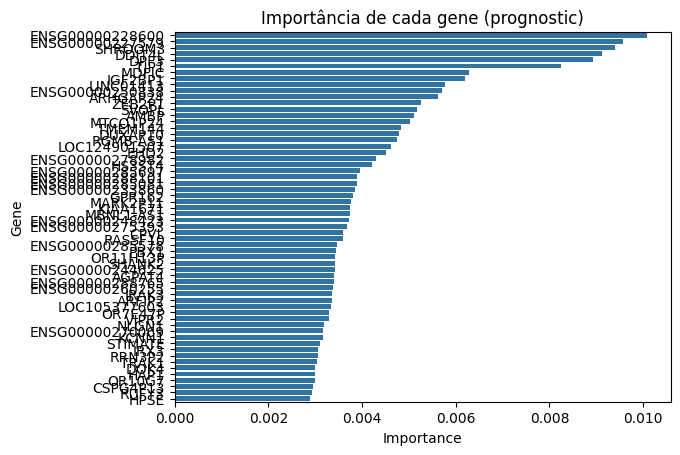

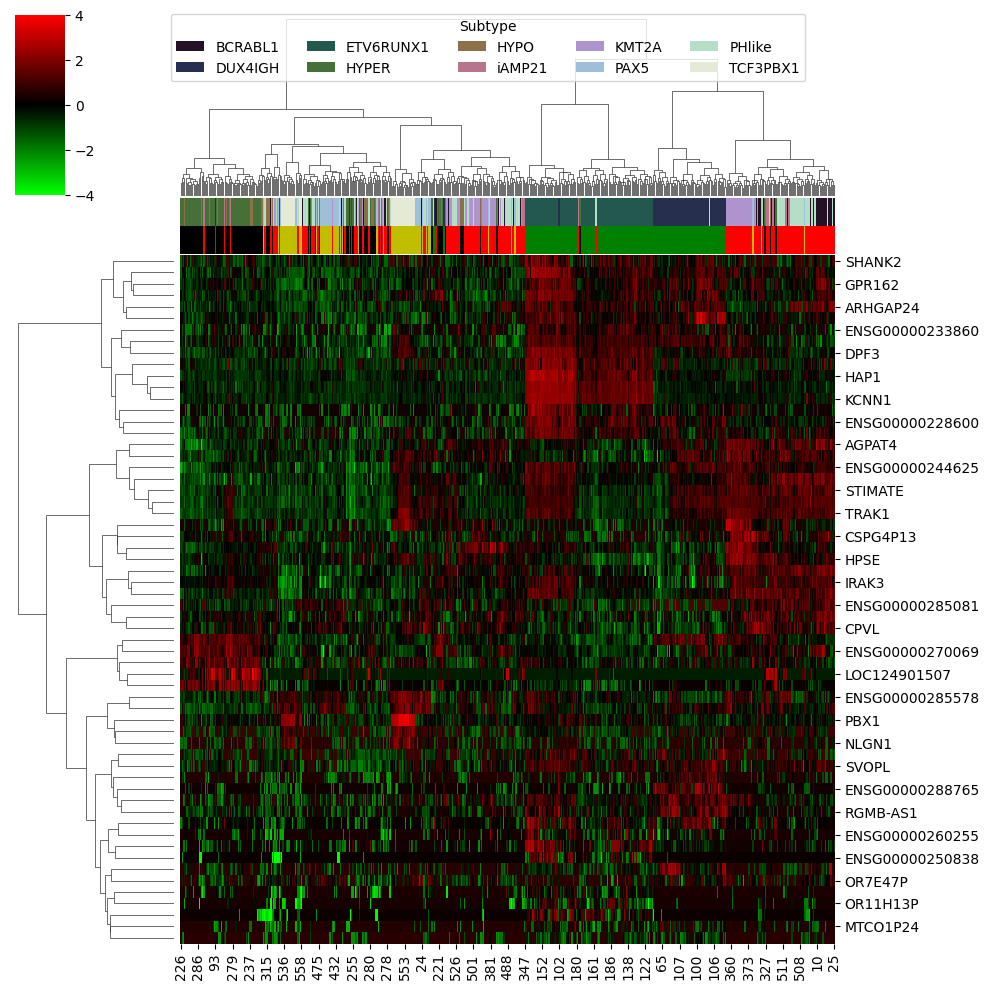

In [42]:
show_cluster("prognostic", top=60)

Acc: 0.6875115106771453, F1 Score: 0.7860495456707881


/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


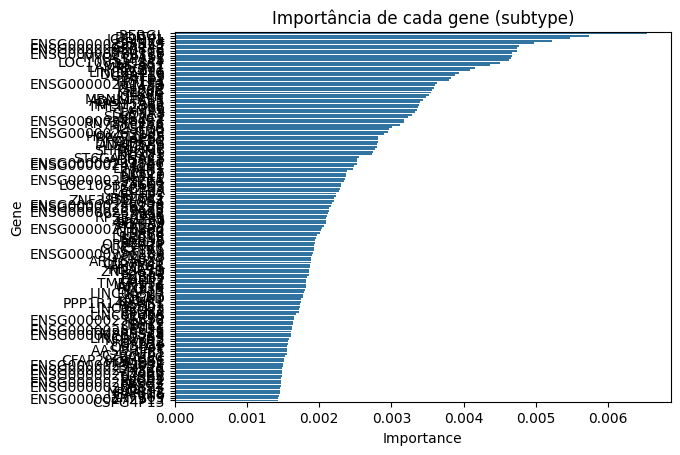

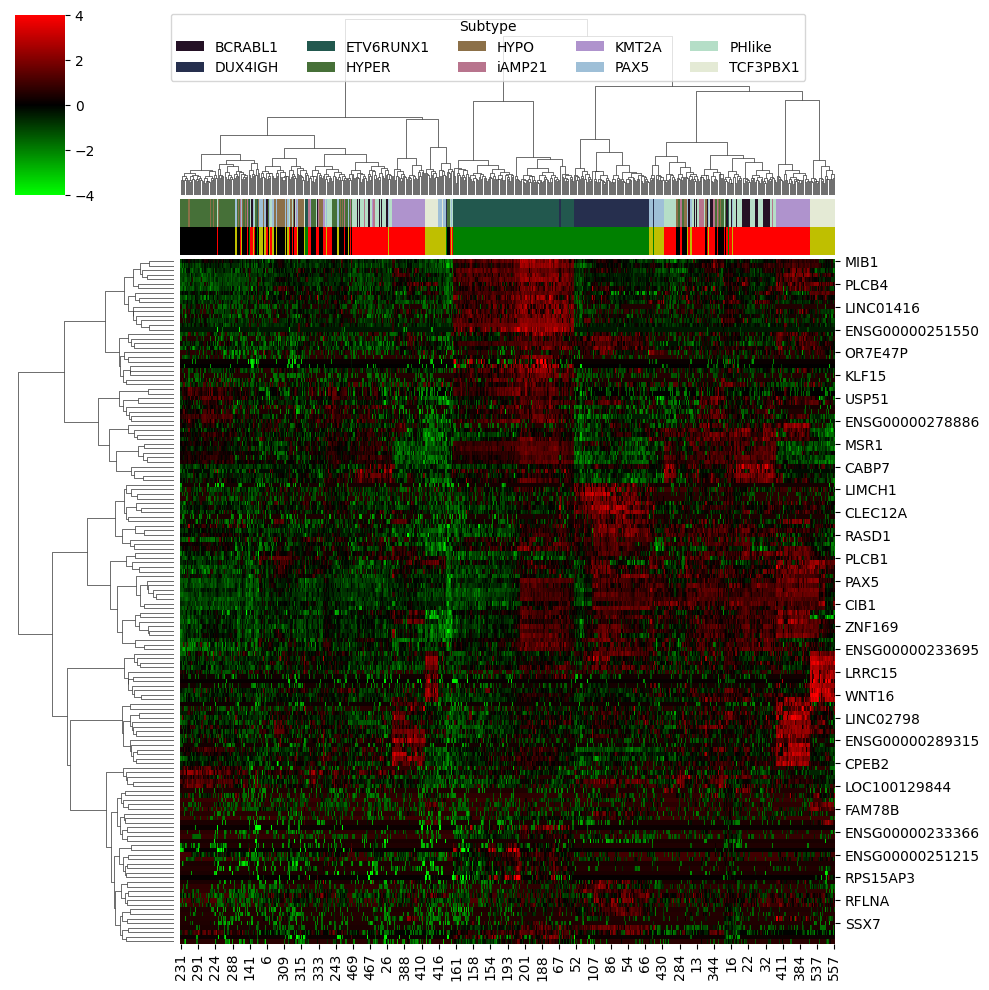

In [11]:
show_cluster("subtype", top=150)

In [10]:
importances_by_subtype = {}
forest_params = {
  "n_estimators": 64,
  "max_depth": 2,
  "class_weight": "balanced"
}
f1s_by_subtype = {}
tops = list(range(5, 60, 5))

genes = set()
for subtype in data["subtype"].unique():
  targeted_data = data.copy()
  targeted_data["subtype_target"] = targeted_data["subtype"] == subtype

  response = train_forest("subtype_target", data=targeted_data, **forest_params)
  print(f"\n======== Subtype {subtype} - F1 Score {response.f1} - ACC {response.acc} ========")

  f1s_by_subtype[subtype] = []
  targets = []
  for top in tops:
    importances_target = get_importances(response.model.feature_importances_, response.feature_names, top=top)
    current_important_data = targeted_data.copy()[["subtype_target", *importances_target.index]]

    search_params = None
    if subtype in ["iAMP21", "BCRABL1"]:
      search_params = {"n_estimators": (2, 4, 8, 16, 32, 64), "max_depth": (2, 4, 16, 64)}

    subset_response = train_forest("subtype_target", data=current_important_data, grid_search_params=search_params, **forest_params)
    f1s_by_subtype[subtype].append(subset_response.f1)
    targets.append(importances_target)

  print(f"F1s for {subtype}: {str(f1s_by_subtype[subtype])}")
  # enumerated_f1s = list(enumerate(f1s_by_subtype[subtype]))
  # i, score = next((x for x in enumerated_f1s if x[1] >= 0.8)) or enumerated_f1s[-1]
  i, max_f1 = max(enumerate(f1s_by_subtype[subtype]), key=lambda x: x[1])
  # i, score = next((x for x in enumerated_f1s if max_score - x[1] <= 0.01))
  print(f"Chosen top: {tops[i]}, {i=} {max_f1=}")

  importances_target = targets[i]
  importances_by_subtype[subtype] = importances_target
  genes |= set(importances_target.index)

  cluster_data = targeted_data.drop(axis=1, labels=["prognostic", "subtype", "subtype_target"])[importances_target.index].transpose()
  col_colors = [targeted_data["subtype_target"].map({ True: "yellow", False: "black" })]

  # g = plot_clustermap(cluster_data, col_colors)
  # g.figure.suptitle(subtype, y=1)
  # plt.show()

  # print(importances_target.to_string())

important_genes = list(genes)


======== Subtype BCRABL1 - F1 Score 0.9374773374773374 - ACC 0.6924812030075188 ========
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 32, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 16, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'cl

<Axes: title={'center': 'Importância de cada gene por subtipo One-vs-All'}, xlabel='Importance', ylabel='Gene'>

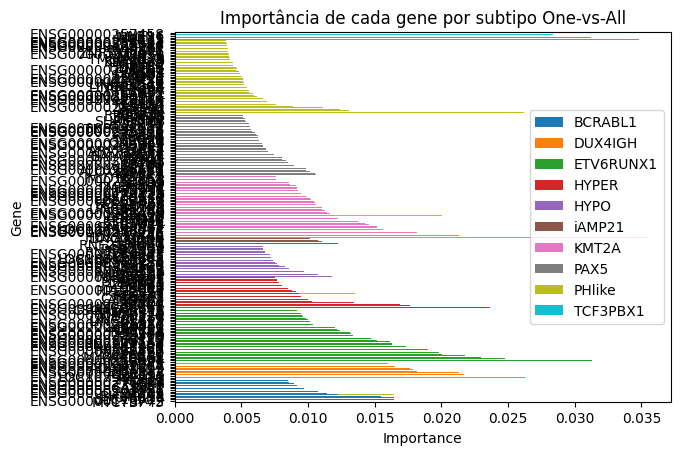

In [23]:
one_vs_all_df = pd.concat(importances_by_subtype.values(), axis=1).fillna(0)
one_vs_all_df.columns = importances_by_subtype.keys()
one_vs_all_df.plot(kind="barh", stacked=True, xlabel='Importance', ylabel='Gene', title="Importância de cada gene por subtipo One-vs-All")

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


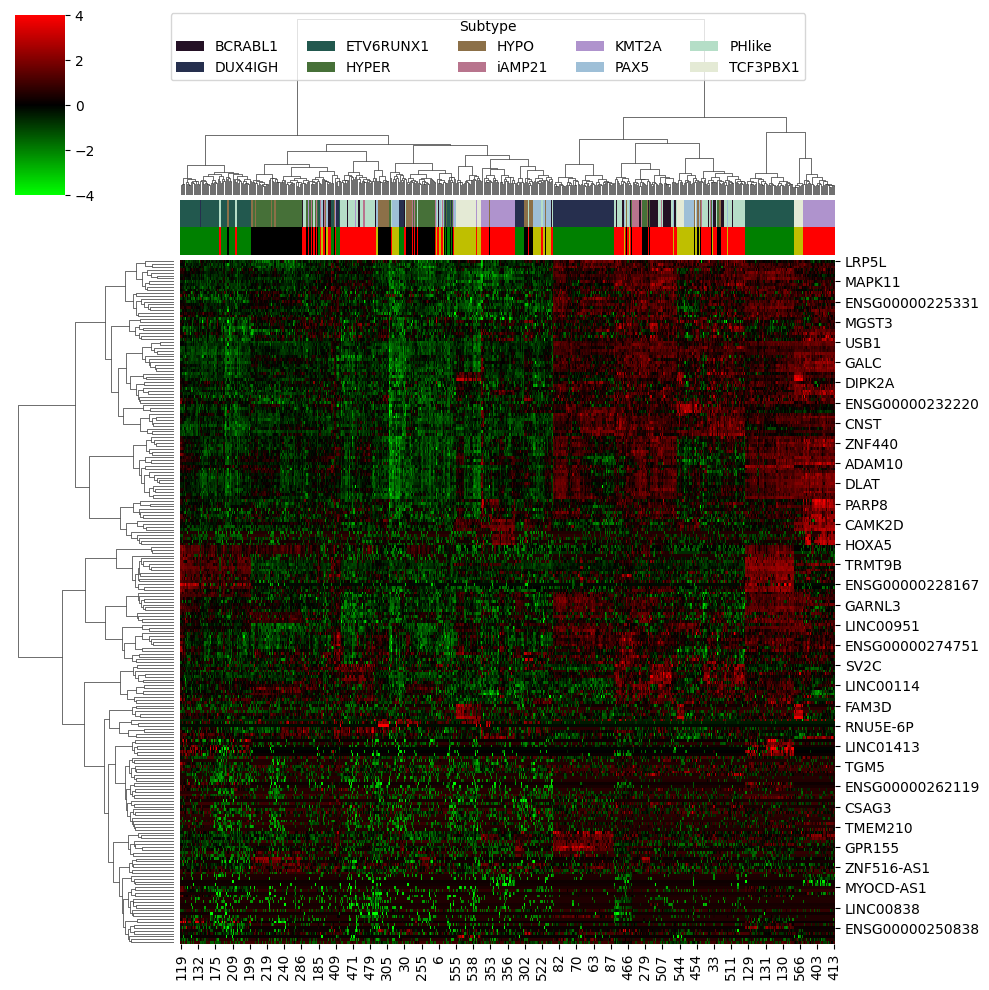

In [24]:
cluster_data = data.drop(axis=1, labels=["prognostic", "subtype"])[important_genes].transpose()

subtypes = data["subtype"]
palette = sns.cubehelix_palette(subtypes.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
lut = dict(zip(map(str, subtypes.unique()), palette))
col_colors = [subtypes.map(lut), data["prognostic"].map({ "POOR": "r", "GOOD": "g", "MODERATE": "y", "UNKNOWN": "black" })]

g = plot_clustermap(cluster_data, col_colors)
plot_legend(g, subtypes, lut)

plt.show()

In [146]:
one_vs_all_search_params = {"n_estimators": (128, 256, 512), "max_depth": (64, 128, 256, None), "class_weight": ("balanced", None), "max_features": (None, "sqrt", "log2")}
one_vs_all_response = train_forest(target="subtype", data=data[["prognostic", "subtype", *important_genes]], grid_search_params=one_vs_all_search_params)
print(one_vs_all_response.model.get_params())
print(f"F1 Score: {one_vs_all_response.f1}, Acc: {one_vs_all_response.acc}")

Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 64, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 512, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 64, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 512, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
F1 Score: 0.893535615150302, Acc: 0.8476342371079213


In [71]:
from model.gradient_boosting import train_gradient_boosting


one_vs_all_search_params = {"learning_rate": (0.01, 0.1, 0.5, 1), "max_depth": (2, 4, 8, 16, 32, 64, None), "max_features": (0.1, 0.15, 0.2, 0.5, 0.75, 0.9), "min_samples_leaf": (5, 10, 20), "l2_regularization": (0, 0.5, 1, 2)}
one_vs_all_response = train_gradient_boosting(target="subtype", data=data[["prognostic", "subtype", *important_genes]], grid_search_params=one_vs_all_search_params)
print(one_vs_all_response.model.get_params())
print(f"F1 Score: {one_vs_all_response.f1}, Acc: {one_vs_all_response.acc}")

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


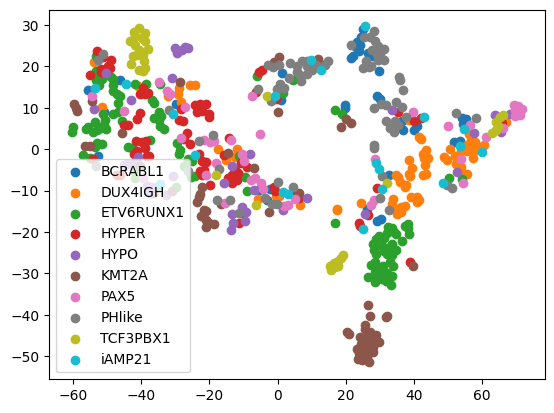

In [26]:
tsne = TSNE(n_components=2, random_state=42, perplexity=18, n_jobs=16, early_exaggeration=20, n_iter=5000).fit_transform(data.drop(axis=1, labels=["prognostic", "subtype"])[important_genes])
fig, ax = plt.subplots()

groups = pd.DataFrame(tsne, columns=["x", "y"]).assign(category=data["subtype"]).groupby("category")
for name, points in groups:
    ax.scatter(points.x, points.y, label=name)

ax.legend()

In [ ]:
for x in [5, 10, 12, 15, 18, 20, 25, 30, 35, 40, 50]:
  for y in [6, 12, 20, 25, 50, 75]:
    print(f"{x} {y}")
    tsne = TSNE(n_components=2, random_state=42, perplexity=x, n_jobs=16, early_exaggeration=y, n_iter=5000).fit_transform(data.drop(axis=1, labels=["prognostic", "subtype"])[important_genes])
    fig, ax = plt.subplots()

    groups = pd.DataFrame(tsne, columns=["x", "y"]).assign(category=data["subtype"]).groupby("category")
    for name, points in groups:
        ax.scatter(points.x, points.y, label=name)

    ax.legend()
    plt.show()